需求是设计一个流程框架，接收一个输入，经过多层判断条件和处理过程，最后输出对输入的分类，未能被分类的输入将被归到单独的一类。  
目的是为了避免多层if...else...的嵌套结构。  
最初的应用场景是需要处理许多表格文件，但这些文件中的格式各不相同，需要人工观察格式并编写相应的处理代码，在处理了一部分文件后，再进行观察，看是否全部规律都被找出、是否全部文件都被正确处理。

# 代码编写
## 基础`class`: `Node`

先定义一个最基础的节点`class`，包含`children`、`parent`和`name`属性，分别代表节点的输出和输入还有命名。  
一个节点只有一个输入，但是可以有多个输出。

In [115]:
class Node():
    def __init__(self,name):
        self.children = []
        self.parent = None
        self.name = name
   
    def add_child(self, node):
        self.children.append(node)
        node.parent = self
   
    def get_children(self):
        return self.children

## 路由器`Router`

除了继承了基础的`Node`的属性和方法外，`Router`还提供了`exit_mapping`属性，能够记录判定条件`tester`和满足条件下对应的`processor`。

In [180]:
class Router(Node):
    def __init__(self, name, default_processor_func=None):
        super().__init__(name)
        self.exit_mapping = {}
        self.default_processor = Processor('Uncategorized', default_processor_func)
        self.add_child(self.default_processor)
        self.default_processor.add_child(Collector('Uncategorized'))
   
    def add_processor(self, processor, tester):
        self.exit_mapping[tester] = processor        
        self.add_child(processor)
        
        return processor
    
    def add_router(self, router):
        self.add_child(router)        
        return router
        
    def do(self, data):
        # find exit and process
        for tester, processor in self.exit_mapping.items():
            if tester(data):
                processor.do(data)
            else:
                self.default_processor.do(data)
                

## 处理函数配置`Processor`

除了继承了基础的`Node`的属性和方法外，`Processor`还提供了`process_func`属性来存储处理函数，并提供了`do`方法来执行处理函数`process_func`。  
在`do`方法中，为什么`next_node`是`children`中的第一个？

In [181]:
class Processor(Node):
    def __init__(self, name, process_func):
        super().__init__(name)
        self.process_func = process_func
        
    def add_processor(self, processor):
        self.add_child(processor)        
        return processor
    
    def add_router(self, router):
        self.add_child(router)        
        return router
    
    def add_collector(self, collector):
        self.add_child(collector)
        return collector   
        
    def do(self, data):
        if self.process_func:
            data = self.process_func(data)
        
        next_node = self.get_children()[0] # Processor has only 1 exit/child
        if isinstance(next_node, Collector):
            next_node.do(self.name, data)
        else:
            next_node.do(data)

## 处理的最终节点`Collector`

In [182]:
class Collector(Node):    
    def __init__(self, name):
        super().__init__(name)
        self.collection = {}

    def do(self, name, data):
        if name in self.collection:
            self.collection[name].append(data)
        else:
            self.collection[name] = [data]

## 管理工具`Manager`

In [183]:
class Manager:
    def __init__(self, collector):
        self.collector = collector
        
    def update(self):
        self.collector.collection = {}

# 运行

In [184]:
collector = Collector('collector')

router = Router('odd_even')


odd_processor = Processor('is_odd', None)
even_processor = Processor('is_even', lambda x:x/2)
devide3_processor = Processor('devide3', lambda x:x/3)
# notdevide3_processor = Processor('devide3_not', None)


router2 = (router.add_processor(odd_processor, lambda x:x%2==1)
    .add_router(Router('devide3_ornot')))
(
    router2
    .add_processor(devide3_processor, lambda x:x%3==0)
    .add_collector(collector)
)
# (
#     router2
#     .add_processor(notdevide3_processor, lambda x:x%3!=0)
#     .add_collector(collector)
# )
router.add_processor(even_processor, lambda x:x%2==0).add_collector(collector)            

In [185]:
router.get_children()[0].get_children()

In [186]:
manager = Manager(collector)

manager.update()

collector.collection

{}

In [187]:
router.do(13)
collector.collection

{}

In [188]:
router.do(14)
collector.collection

{'is_even': [7.0]}

In [189]:
router.do(15)
collector.collection

{'devide3': [5.0], 'is_even': [7.0]}

In [190]:
router.do(15.5)
collector.collection

{'devide3': [5.0], 'is_even': [7.0]}

In [191]:
router.default_processor.children[0].collection

{'Uncategorized': [13, 14, 15, 15.5, 15.5]}

# 流程可视化

In [162]:
from IPython.display import display, Image

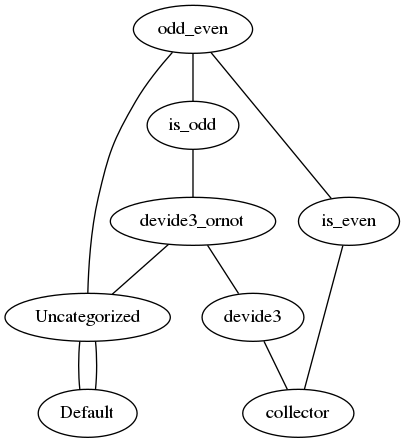

In [163]:
from graphviz import Graph

g = Graph('G', filename='process.gv', engine='dot', format='png')

def connect_edge(node, g):
    if node.children:
        for node_child in node.children:
            g.edge(node.name, node_child.name)
            connect_edge(node_child, g)
    return g

g = connect_edge(router, g)
display(Image(g.render()))